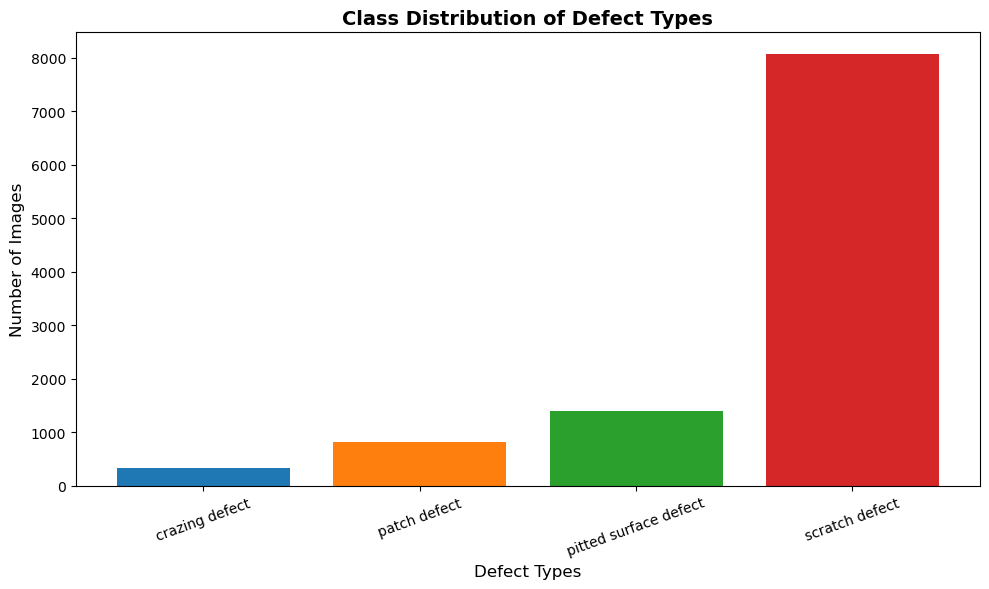

In [18]:
import os
import matplotlib.pyplot as plt

# Replace with your dataset path
dataset_path = r'C:\Users\anura\Desktop\Img_Pro\train_sorted'

# Get class-wise counts
class_names = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
class_counts = {}
for class_name in class_names:
    folder_path = os.path.join(dataset_path, class_name)
    count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    class_counts[class_name] = count

# Colors for bars
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# Plot
plt.figure(figsize=(10, 6))
bars = plt.bar(class_counts.keys(), class_counts.values(), color=colors)

# Removed the label-drawing loop here

# Titles and labels
plt.title('Class Distribution of Defect Types', fontsize=14, fontweight='bold')
plt.xlabel('Defect Types', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


In [19]:
import os
from collections import defaultdict

dataset_path = r'C:\Users\anura\Desktop\Img_Pro\train_sorted'
class_counts = defaultdict(int)

# Count images per class
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        class_counts[class_name] = len(os.listdir(class_dir))

print("Original class distribution:", dict(class_counts))

Original class distribution: {'crazing defect': 330, 'patch defect': 826, 'pitted surface defect': 1404, 'scratch defect': 8070}


In [24]:
import os
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
import shutil

# Configuration
dataset_path = r'C:\Users\anura\Desktop\Img_Pro\train_sorted'  # Original dataset
output_dir = r'C:\Users\anura\Desktop\Img_Pro\train_balanced'  # Output directory for upsampled data
target_count = 4000  # Target images per minority class
minority_classes = ['crazing defect', 'patch defect', 'pitted surface defect']  # Classes to upsample

# 1. Create output directory structure (including scratch defect)
os.makedirs(output_dir, exist_ok=True)
for class_name in minority_classes:
    os.makedirs(os.path.join(output_dir, class_name), exist_ok=True)

# 2. First copy ALL original images to maintain the original dataset
print("Copying original images...")
for class_name in os.listdir(dataset_path):
    src_class_dir = os.path.join(dataset_path, class_name)
    dst_class_dir = os.path.join(output_dir, class_name)
    
    # Skip non-image files
    images = [f for f in os.listdir(src_class_dir) 
             if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    # Copy original images
    for img_name in images:
        src = os.path.join(src_class_dir, img_name)
        dst = os.path.join(dst_class_dir, img_name)
        shutil.copy2(src, dst)

# 3. Configure augmentation - customized for defect types
datagen = ImageDataGenerator(
    rotation_range=15,        # Good for all defect types
    width_shift_range=0.1,   # Small shifts preserve defect locations
    height_shift_range=0.1,
    shear_range=0.1,         # Mild shear maintains defect shapes
    zoom_range=[0.9, 1.1],   # Slight zoom variations
    horizontal_flip=True,    # Especially useful for linear defects
    vertical_flip=True,      # Useful for symmetrical defects
    brightness_range=[0.9, 1.1],  # Small brightness changes
    fill_mode='reflect'      # Better edge handling
)

# 4. Upsample only the minority classes
for class_name in minority_classes:
    class_dir = os.path.join(output_dir, class_name)
    current_images = [f for f in os.listdir(class_dir) 
                     if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    num_current = len(current_images)
    num_needed = max(0, target_count - num_current)  # Ensure non-negative
    
    print(f"\nUpsampling {class_name} from {num_current} to {target_count} images...")
    
    if num_needed <= 0:
        print(f"Class already has {num_current} images (>= {target_count})")
        continue
    
    # Calculate how many augmentations to generate per original image
    augs_per_image = int(np.ceil(num_needed / num_current))
    
    generated_count = 0
    for img_name in current_images:
        if generated_count >= num_needed:
            break
            
        img_path = os.path.join(class_dir, img_name)
        
        try:
            # Load and augment image
            img = Image.open(img_path)
            img_array = img_to_array(img)
            img_array = img_array.reshape((1,) + img_array.shape)
            
            # Generate augmented versions
            for batch in datagen.flow(img_array, batch_size=1):
                aug_img = Image.fromarray(batch[0].astype('uint8'))
                new_name = f"aug_{generated_count+1}_{img_name}"
                save_path = os.path.join(class_dir, new_name)
                
                # Save with original format
                ext = os.path.splitext(img_name)[1].lower()
                if ext in ('.jpg', '.jpeg'):
                    aug_img.save(save_path, quality=95)
                else:
                    aug_img.save(save_path)
                
                generated_count += 1
                print(f"\rGenerated: {generated_count}/{num_needed}", end='')
                
                if generated_count >= num_needed:
                    break
                    
        except Exception as e:
            print(f"\nError processing {img_name}: {str(e)}")
    
    print(f"\nFinished {class_name}. Total images now: {num_current + generated_count}")

# Final verification
print("\nFinal class counts:")
for class_name in minority_classes + ['scratch defect']:
    class_dir = os.path.join(output_dir, class_name)
    count = len([f for f in os.listdir(class_dir) 
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    print(f"{class_name}: {count} images")

Copying original images...

Upsampling crazing defect from 330 to 4000 images...
Generated: 3670/3670
Finished crazing defect. Total images now: 4000

Upsampling patch defect from 826 to 4000 images...
Generated: 3174/3174
Finished patch defect. Total images now: 4000

Upsampling pitted surface defect from 1404 to 4000 images...
Generated: 2596/2596
Finished pitted surface defect. Total images now: 4000

Final class counts:
crazing defect: 4000 images
patch defect: 4000 images
pitted surface defect: 4000 images
scratch defect: 8070 images


In [25]:
import os
import random
import shutil

# Configuration
balanced_dir = r'C:\Users\anura\Desktop\Img_Pro\train_balanced'  # Path to your balanced directory
class_to_downsample = 'scratch defect'  # Class to downsample
target_count = 4000  # Target number of images

# Path to the class directory
class_dir = os.path.join(balanced_dir, class_to_downsample)

# Verify directory exists
if not os.path.exists(class_dir):
    raise FileNotFoundError(f"Directory not found: {class_dir}")

# Get all image files (supports multiple extensions)
image_extensions = ('.jpg', '.jpeg', '.png', '.bmp')
current_images = [f for f in os.listdir(class_dir) 
                 if f.lower().endswith(image_extensions)]

current_count = len(current_images)
print(f"Current images in {class_to_downsample}: {current_count}")

if current_count <= target_count:
    print(f"No downsampling needed - already has {current_count} images")
else:
    # Randomly select target_count images to keep
    images_to_keep = random.sample(current_images, target_count)
    
    # Create temporary directory for safety
    temp_dir = os.path.join(balanced_dir, 'temp_scratch')
    os.makedirs(temp_dir, exist_ok=True)
    
    # Move selected images to temp directory
    for img_name in images_to_keep:
        src = os.path.join(class_dir, img_name)
        dst = os.path.join(temp_dir, img_name)
        shutil.move(src, dst)
    
    # Remove all remaining images in original directory
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        if os.path.isfile(img_path):
            os.remove(img_path)
    
    # Move selected images back
    for img_name in os.listdir(temp_dir):
        src = os.path.join(temp_dir, img_name)
        dst = os.path.join(class_dir, img_name)
        shutil.move(src, dst)
    
    # Remove temp directory
    os.rmdir(temp_dir)
    
    # Verify final count
    final_count = len(os.listdir(class_dir))
    print(f"Downsampling complete. Final count: {final_count} images")

Current images in scratch defect: 8070
Downsampling complete. Final count: 4000 images


Found 16000 images belonging to 4 classes.
Found 666 images belonging to 4 classes.
Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead
Epoch 1/3


c:\Users\anura\anaconda3\envs\tensorflow_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


250/250 ━━━━━━━━━━━━━━━━━━━━ 669s 3s/step - accuracy: 0.7621 - loss: 0.7518 - val_accuracy: 0.4766 - val_loss: 1.1312 - learning_rate: 0.0010
Epoch 2/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 657s 3s/step - accuracy: 0.8544 - loss: 0.3629 - val_accuracy: 0.8355 - val_loss: 0.4744 - learning_rate: 0.0010
Epoch 3/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 624s 2s/step - accuracy: 0.8738 - loss: 0.3109 - val_accuracy: 0.8439 - val_loss: 0.4698 - learning_rate: 0.0010


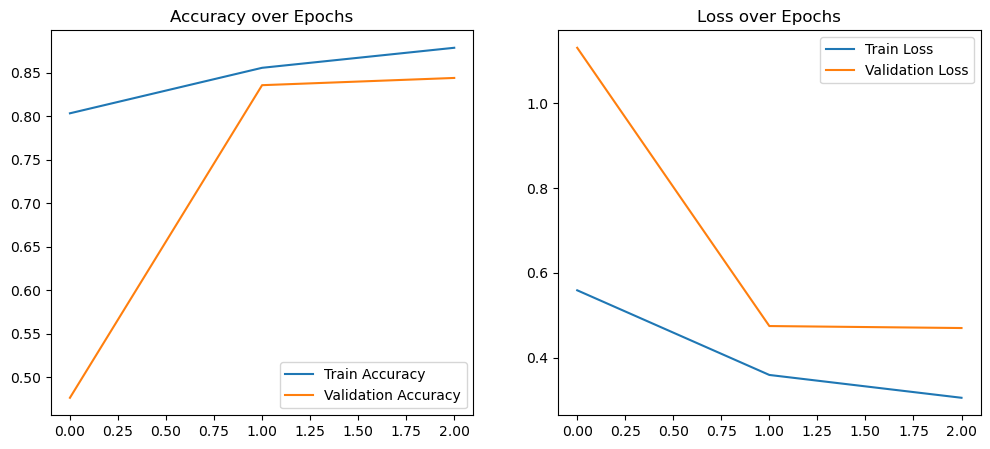

    740/Unknown 317s 428ms/step - accuracy: 0.8119 - loss: 0.5175

KeyboardInterrupt: 

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Configuration
train_dir = r'C:\Users\anura\Desktop\Img_Pro\train_balanced'
val_dir = r'C:\Users\anura\Desktop\Img_Pro\valid_sorted'
img_size = (224, 224)
batch_size = 64
num_classes = 4
epochs = 3  # Changed to 5 epochs

# Data Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Convert to tf.data.Dataset for better performance
train_ds = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, img_size[0], img_size[1], 3], [None, num_classes])
).cache().prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_generator(
    lambda: val_generator,
    output_types=(tf.float32, tf.float32),
    output_shapes=([None, img_size[0], img_size[1], 3], [None, num_classes])
).cache().prefetch(tf.data.AUTOTUNE)

# Model Architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(img_size[0], img_size[1], 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),
    
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

# Compile with RMSprop optimizer
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True),  # Changed to .keras format
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
]

# Train the model
history = model.fit(
    train_ds,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_ds,
    validation_steps=val_generator.samples // batch_size,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

# Evaluate and save
val_loss, val_acc = model.evaluate(val_ds)
print(f'\nFinal Validation Accuracy: {val_acc:.4f}')
print(f'Final Validation Loss: {val_loss:.4f}')

# Save the final model (not just best checkpoint)
model.save('final_model.keras')  # Modern .keras format
print("Model saved as 'final_model.keras'")